In [277]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import scipy.stats as stats

pd.set_option('display.float_format', lambda x: '%.2f' % x)
path = '../../../../playwright/results/core-web-vitals/testrun-8/'

def graph_row(plot_func, datasets, height=3, width=20):
    cols = len(datasets)
    fig, axes = plt.subplots(ncols=cols, figsize=(width, height))
    plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)
    for x, (name, dataset) in enumerate(datasets.items()):
        plot_func(dataset, axes[x], idx=x)
        axes[x].set_title(name)
    return plt

In [278]:
df = pd.read_csv(f'{path}2024-12-16T09:36:50.835Z_results-csr.csv', sep=',')
df_t = pd.read_csv(f'{path}2024-12-16T11:08:37.924Z_results-csr-throttled.csv', sep=',')
df_ht = pd.read_csv(f'{path}2024-12-16T12:37:45.058Z_results-csr-throttled-heavy.csv', sep=',')

features = ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask', 'longTasks', 'nf:init', 'nf:config','nf:loaded']

dirty_dfs = {
    'default': df[5:],
    'throttled': df_t[5:],
    'heavy': df_ht[5:],
}

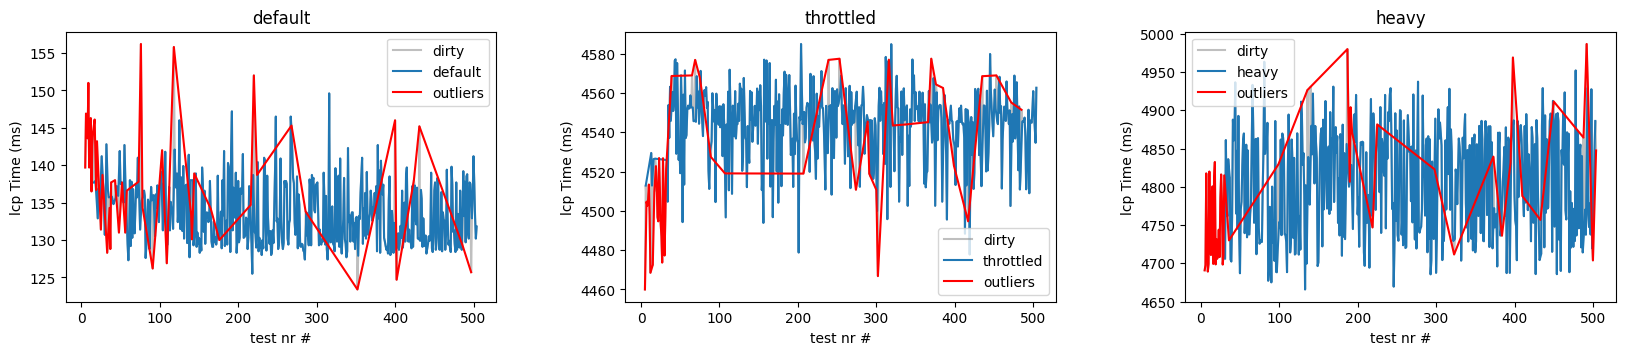

In [279]:
def detect_outliers(_df, _features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(_df[_features])
    return outliers == 1

def plot_outliers(_df, d, loc, mask):
    loc.plot(_df['lcp'], label='dirty', color='gray', alpha=0.5)
    loc.plot(_df['lcp'][mask[d]], label=d)
    loc.plot(_df['lcp'][~mask[d]], label='outliers', color='red')

    loc.set_title(d)
    loc.set_ylabel(f'lcp Time (ms)') 
    loc.set_xlabel('test nr #') 
    loc.legend()

masks = {}
dfs = {}
target_features = ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb']

for name, _df in dirty_dfs.items():
    mask = detect_outliers(_df, target_features)
    masks[name] = mask
    dfs[name] = _df[mask].copy()

graph_row(lambda _ds, loc, idx: plot_outliers(_ds, list(dfs.keys())[idx], loc, masks), dirty_dfs)
plt.show()

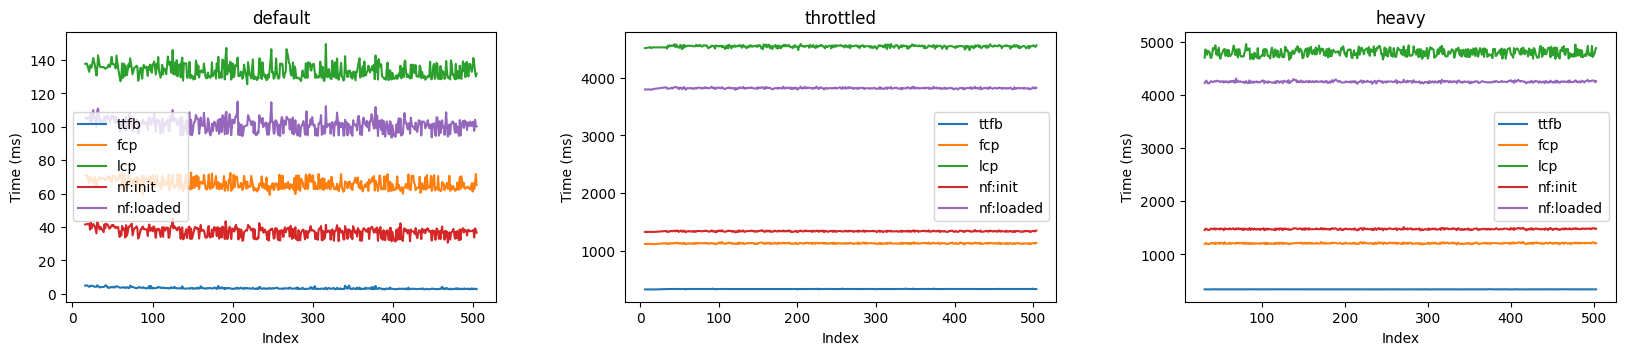

In [280]:
def plot_line(dataset, loc, idx):
    for t in ['ttfb', 'fcp', 'lcp', 'nf:init', 'nf:loaded']:
        loc.plot(dataset[t], label=t)
    loc.set_xlabel('Index')
    loc.set_ylabel('Time (ms)')
    loc.legend()

graph_row(plot_line, dfs)
plt.show()

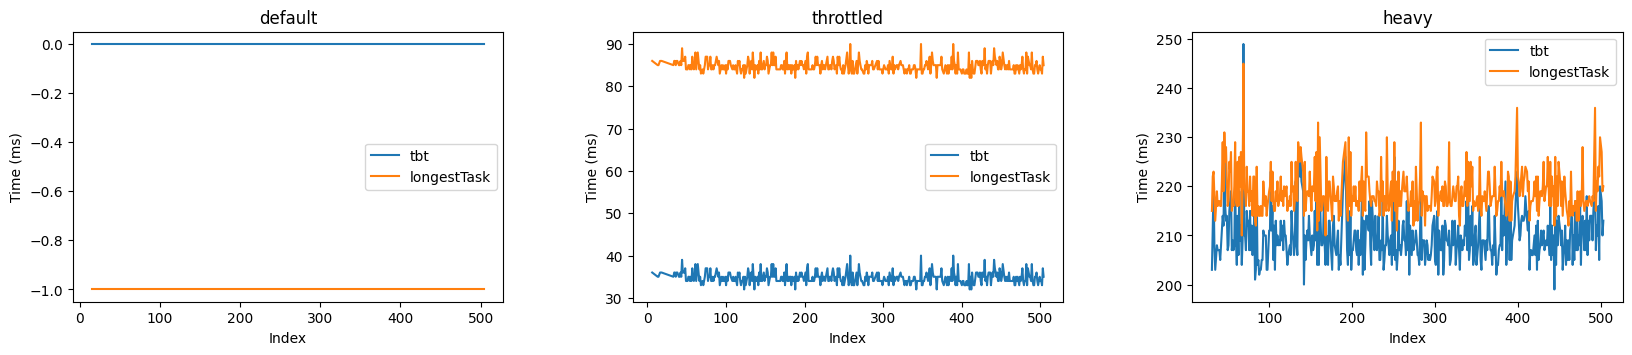

In [281]:
def plot_line(dataset, loc, idx):
    for t in ['tbt', 'longestTask']:
        loc.plot(dataset[t], label=t)
    loc.set_xlabel('Index')
    loc.set_ylabel('Time (ms)')
    loc.legend()

graph_row(plot_line, dfs)
plt.show()

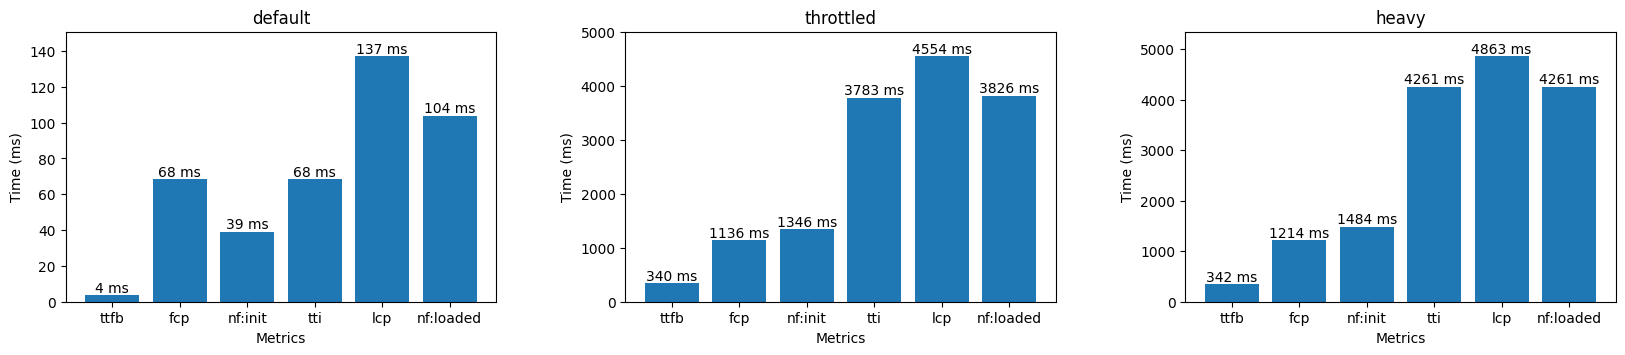

In [282]:
def plot_timeline_bars(dataset, loc, idx):
    metrics = ['ttfb', 'fcp', 'nf:init', 'tti', 'lcp', 'nf:loaded']
    quantiles = [dataset[t].quantile(0.75) for t in metrics]
    bars = loc.bar(metrics, quantiles, label='75th percentile')
    loc.set_xlabel('Metrics')
    loc.set_ylabel('Time (ms)')
    
    for bar in bars:
        height = bar.get_height()
        loc.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.0f} ms', ha='center', va='bottom')
    
    loc.set_ylim(0, max(quantiles) * 1.1)

graph_row(plot_timeline_bars, dfs)
plt.show()

In [283]:
dfs['default'].describe()

,idx,navTime,totalTime,lcp,fcp,ttfb,tbt,tti,longTasks,longestTask,nf:init,nf:config,nf:loaded,error
count,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,0.00
mean,269.85,8.09,78.04,133.48,65.77,3.29,0.00,65.77,0.00,-1.00,37.18,42.12,101.28,NaN
std,137.42,0.80,10.80,4.19,3.17,0.49,0.00,3.17,0.00,0.00,2.81,3.17,3.93,NaN
min,17.00,7.00,62.00,125.50,59.20,2.60,0.00,59.20,0.00,-1.00,30.60,35.50,93.50,NaN
25%,154.25,8.00,71.00,129.70,63.00,2.90,0.00,63.00,0.00,-1.00,34.92,39.30,98.30,NaN
50%,272.50,8.00,74.00,132.80,65.25,3.20,0.00,65.25,0.00,-1.00,37.90,42.85,101.65,NaN
75%,386.75,9.00,89.00,137.00,68.50,3.50,0.00,68.50,0.00,-1.00,39.10,44.40,103.90,NaN
max,505.00,10.00,105.00,149.60,72.60,5.10,0.00,72.60,0.00,-1.00,45.00,50.40,115.10,NaN


In [284]:
dfs['throttled'].describe()

,idx,navTime,totalTime,lcp,fcp,ttfb,tbt,tti,longTasks,longestTask,nf:init,nf:config,nf:loaded,error
count,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,0.00
mean,265.60,335.82,3808.07,4543.92,1131.01,340.01,34.79,3776.53,1.00,84.79,1341.10,1682.16,3819.91,NaN
std,138.40,1.83,18.81,18.10,7.25,1.46,1.37,10.62,0.00,1.37,7.40,9.10,9.81,NaN
min,7.00,327.00,3766.00,4477.80,1113.40,332.40,32.00,3746.50,1.00,82.00,1321.40,1650.70,3790.40,NaN
25%,147.25,335.00,3791.00,4535.75,1127.40,339.80,34.00,3769.73,1.00,84.00,1337.00,1674.60,3813.85,NaN
50%,262.50,336.00,3810.00,4545.90,1129.40,339.90,35.00,3776.85,1.00,85.00,1339.40,1681.65,3820.00,NaN
75%,386.50,337.00,3824.00,4553.88,1135.90,340.30,35.00,3783.17,1.00,85.00,1345.80,1687.97,3825.98,NaN
max,505.00,343.00,3853.00,4585.00,1153.00,347.70,40.00,3809.80,1.00,90.00,1360.70,1703.90,3847.30,NaN


In [285]:
dfs['heavy'].describe()

,idx,navTime,totalTime,lcp,fcp,ttfb,tbt,tti,longTasks,longestTask,nf:init,nf:config,nf:loaded,error
count,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,0.00
mean,266.65,345.44,4269.99,4806.32,1209.22,341.92,209.73,4251.78,3.00,218.84,1477.83,1824.77,4252.08,NaN
std,136.54,1.25,16.03,68.64,8.87,0.84,5.10,14.45,0.00,4.34,10.19,10.98,14.48,NaN
min,32.00,342.00,4227.00,4665.80,1187.40,339.90,199.00,4212.60,3.00,210.00,1451.30,1790.10,4213.00,NaN
25%,148.25,345.00,4258.00,4745.40,1203.35,341.20,206.00,4242.13,3.00,216.00,1472.03,1817.95,4242.37,NaN
50%,267.50,345.00,4270.00,4815.70,1209.75,341.70,209.00,4252.20,3.00,218.00,1477.30,1826.60,4252.55,NaN
75%,382.75,346.00,4280.75,4863.18,1214.30,342.50,213.00,4260.88,3.00,221.00,1484.30,1831.98,4261.10,NaN
max,504.00,349.00,4338.00,4963.40,1236.80,345.20,249.00,4312.00,3.00,245.00,1514.90,1873.20,4312.60,NaN


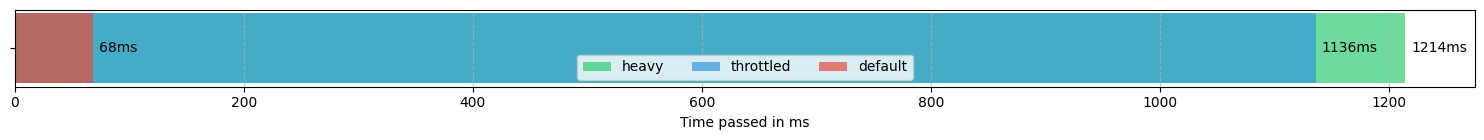

In [286]:
fig, ax = plt.subplots(figsize=(15, 1.5))

fcp_values = [df['fcp'].quantile(0.75) for df in dfs.values()]

bar_height = 0.25
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars = []
for i, (name, value) in enumerate(zip(reversed(dfs.keys()), reversed(fcp_values))):
    bar = ax.barh(0.5, value, height=bar_height, 
                 label=name, color=colors[i], alpha=0.7)
    bars.append(bar)

ax.set_yticks([0.5])
ax.set_yticklabels([''])
ax.set_xlabel('Time passed in ms')

ax.grid(True, axis='x', linestyle='--', alpha=0.7)

for i, bar in enumerate(bars):
    width = bar[0].get_width()
    ax.text(width + 5, bar[0].get_y() + bar[0].get_height()/2, 
            f'{fcp_values[-(i+1)]:.0f}ms', 
            va='center')

ax.legend(loc='lower center', ncols=3)

plt.tight_layout()

plt.show()

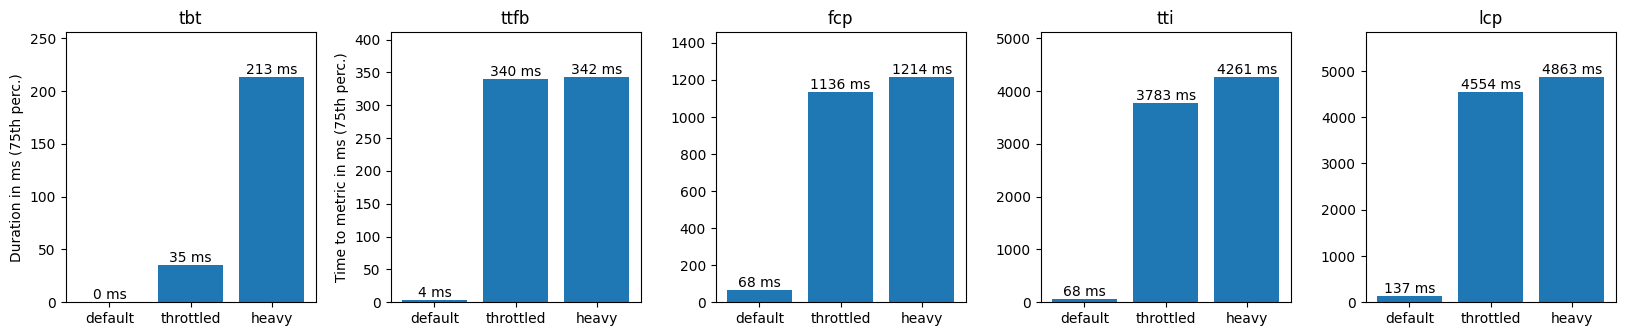

In [287]:
features = ['tbt','ttfb', 'fcp', 'tti', 'lcp']
fig, axes = plt.subplots(ncols=len(features), figsize=(20, 3))
plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)

for idx, feature in enumerate(features):
    percentiles = {d: dfs[d][feature].quantile(0.75) for d in dfs.keys()}
    bars = axes[idx].bar(percentiles.keys(), percentiles.values())
    
    max_height = max(percentiles.values())
    axes[idx].set_ylim(0, max_height * 1.2)
    
    for bar in bars:
        height = bar.get_height()
        label = f'{int(round(height, 0))} ms'
        axes[idx].text(bar.get_x() + bar.get_width()/2., height, label, ha='center', va='bottom')
    
    axes[idx].set_title(feature)
    if idx == 0:
        axes[idx].set_ylabel('Duration in ms (75th perc.)')
    if idx == 1:
        axes[idx].set_ylabel('Time to metric in ms (75th perc.)')

plt.show()

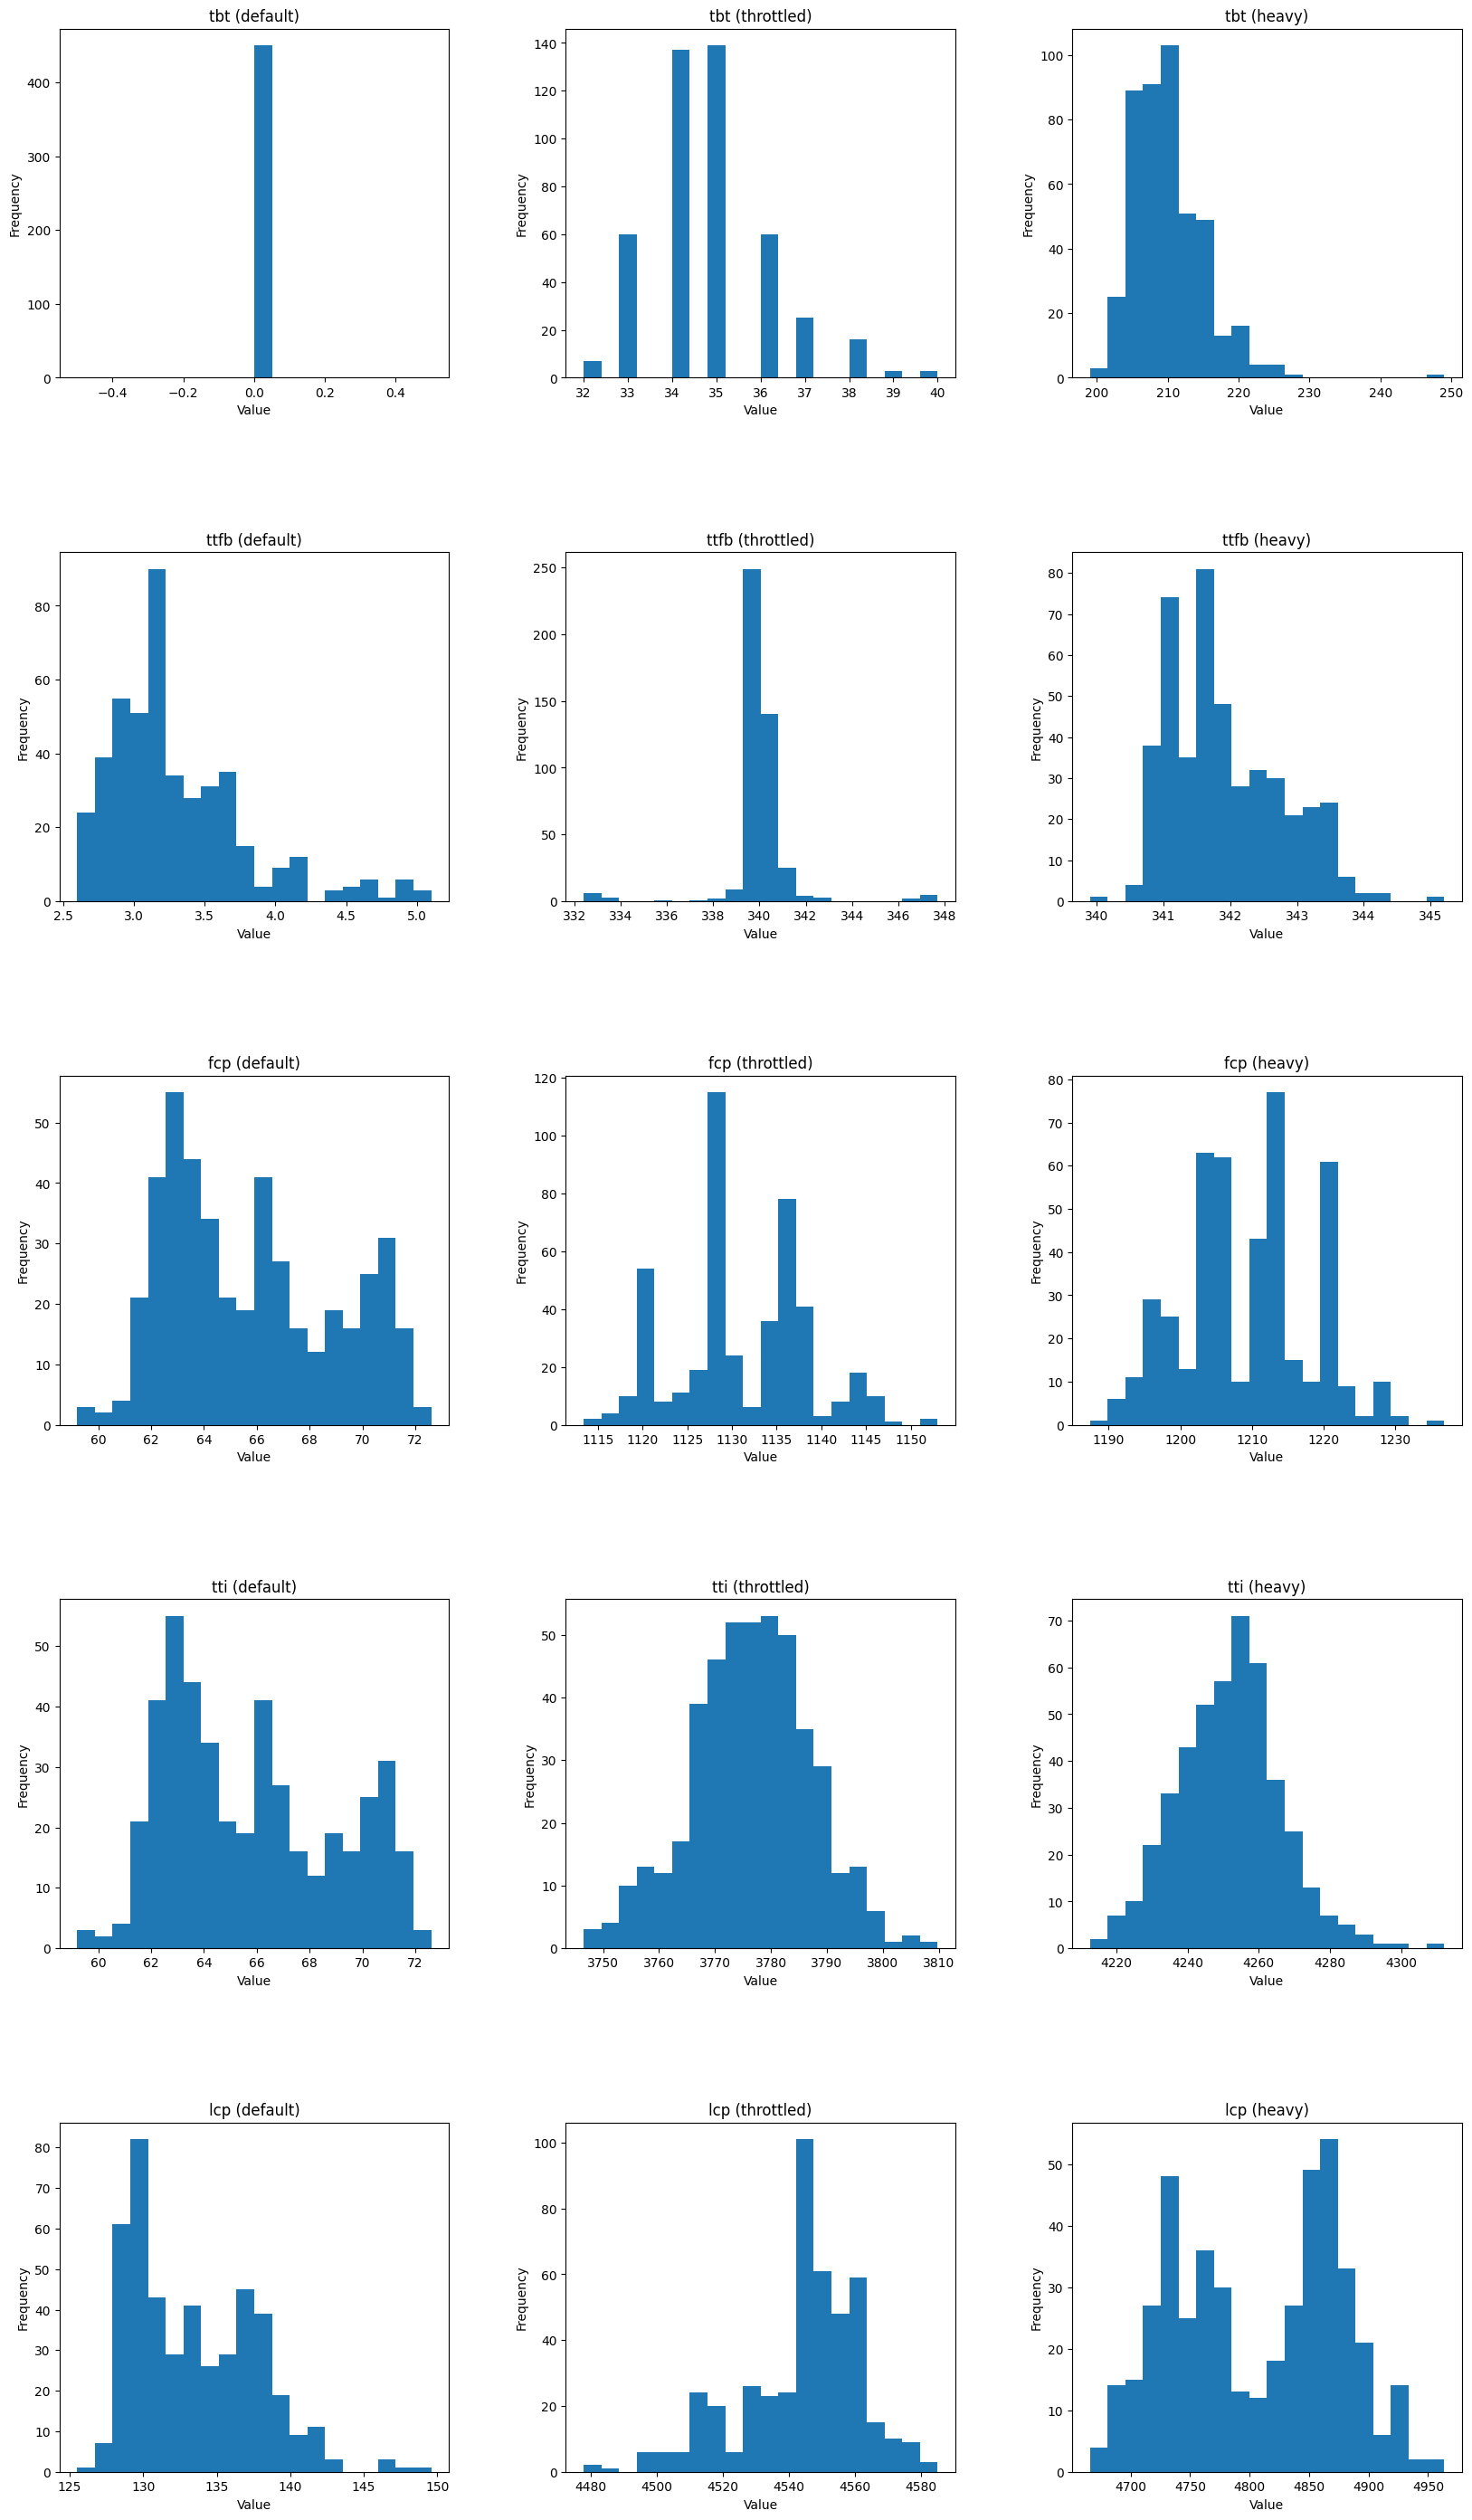

In [288]:
target_features = ['tbt', 'ttfb', 'fcp', 'tti', 'lcp']

fig, axes = plt.subplots(nrows=len(target_features), ncols=len(dfs.keys()), figsize=(20, 6*len(target_features)))
plt.subplots_adjust(hspace=0.5, wspace=0.3, top=0.95, bottom=0.05)

for y, f in enumerate(target_features):
    for x, d in enumerate(dfs.keys()):
        axes[y, x].hist(dfs[d][f], bins=20)
        axes[y, x].set_title(f'{f} ({d})')
        axes[y, x].set_xlabel('Value')
        axes[y, x].set_ylabel('Frequency')

plt.show()

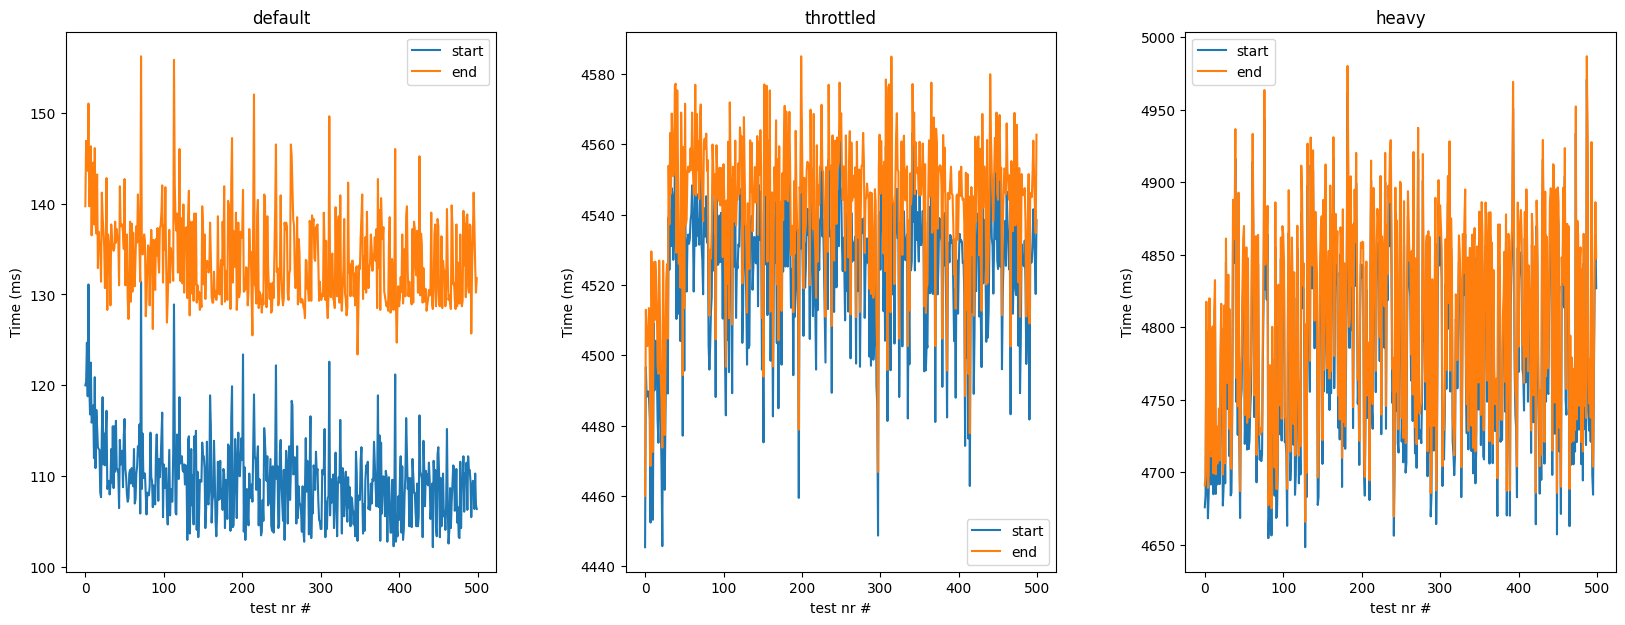

In [289]:
det_df = pd.read_csv(f'{path}details/2024-12-16T09:36:50.840Z_details-csr.csv', sep=',')
det_df_t = pd.read_csv(f'{path}details/2024-12-16T11:08:37.930Z_details-csr-throttled.csv', sep=',')
det_df_ht = pd.read_csv(f'{path}details/2024-12-16T12:37:45.062Z_details-csr-throttled-heavy.csv', sep=',')

lcp_dfs = {
  'default': det_df[(det_df['type'] == 'LCP') & (det_df['idx'] > 5)].reset_index(drop=True),
  'throttled': det_df_t[(det_df_t['type'] == 'LCP') & (det_df_t['idx'] > 5)].reset_index(drop=True),
  'heavy': det_df_ht[(det_df_ht['type'] == 'LCP') & (det_df_ht['idx'] > 5)].reset_index(drop=True),
}
lcp_features = ['start','end','duration','name','element','url','id']


def plot_lcp_line(_df, loc, idx):
  for f in ['start', 'end']:
    loc.plot(_df[f], label=f)
  
  loc.set_title("LCP")
  loc.set_ylabel('Time (ms)')
  loc.set_xlabel('test nr #')
  loc.legend()

graph_row(plot_lcp_line, lcp_dfs, height=6)
plt.show()